In [1]:
import sys
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# import regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
import pickle

from openbb import obb
sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
from utils import local_data_interface as ldi
from assets.api_credentials import openbb_pat
obb.account.login(pat=openbb_pat, remember_me=True)

from utils import local_data_interface as ldi
import indicators as inds
from indicators import pandas_ta_indicators as pti
from indicators import tulipy_indicators as ti
from indicators import metaindicators as mi
from indicators import custom_indicators as ci
from indicators import sets

from utils import ohlc_utils as ou

plt.rcParams['figure.figsize'] = [16, 4]

%load_ext autoreload
%autoreload 2

### Load data

In [2]:
#get raw ohlc data
symbols = sets.T001

ohlc_data = {}
for symbol in symbols:
    try:
        df = ldi.get_ticker(symbol=symbol, start_date="1980-01-01", end_date='2024-01-01', interval='1d')
        ohlc_data[symbol] = df
    except Exception as e:
        print(f"Error processing {symbol}: {e}")




In [3]:
# extract features
set = sets.perc_from_extrema
indicator_data = {}
for symbol in ohlc_data.keys():
    try:
        extractor = inds.Extractor(set) 
        ind_df = extractor.extract(df)
        
        #normalize each column of indicator data
        for c in ind_df.columns:
            if c != 'Date':
                ind_df[c] = (ind_df[c] - np.nanmean(ind_df[c])) / np.nanstd(ind_df[c])
        
        indicator_data[symbol] = ind_df
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

In [4]:
# print nan % per column
for col in indicator_data['MSFT'].columns:
    nan_count = indicator_data['MSFT'][col].isna().sum()
    total_count = len(indicator_data['MSFT'][col])
    nan_percentage = (nan_count / total_count) * 100
    if nan_percentage > 0:
        print(f"{col}: {nan_percentage:.2f}% NaN values")


percent_from_local_high(period=2,key=close): 0.01% NaN values
percent_from_local_high(period=3,key=close): 0.02% NaN values
percent_from_local_high(period=5,key=close): 0.04% NaN values
percent_from_local_high(period=10,key=close): 0.08% NaN values
percent_from_local_high(period=14,key=close): 0.12% NaN values
percent_from_local_high(period=21,key=close): 0.18% NaN values
percent_from_local_high(period=30,key=close): 0.26% NaN values
percent_from_local_high(period=50,key=close): 0.44% NaN values
percent_from_local_high(period=100,key=close): 0.89% NaN values
percent_from_local_high(period=200,key=close): 1.79% NaN values
percent_from_local_high(period=330,key=close): 2.97% NaN values
percent_from_local_low(period=2,key=close): 0.01% NaN values
percent_from_local_low(period=3,key=close): 0.02% NaN values
percent_from_local_low(period=5,key=close): 0.04% NaN values
percent_from_local_low(period=10,key=close): 0.08% NaN values
percent_from_local_low(period=14,key=close): 0.12% NaN values


In [5]:
# create target variable that is the percent change between current close and the future 14 day mean
future_mean_window = 5 # days
target_data = {}
for symbol in ohlc_data.keys():
    try:
        
        ohlc_df = ohlc_data[symbol]
        target_df = pd.DataFrame(index=ohlc_df.index)
        target_df['target'] = ohlc_df['close'].rolling(window=future_mean_window).mean().shift(-future_mean_window) / ohlc_df['close']
        target_df['target'] = (target_df['target'] - target_df['target'].mean()) / target_df['target'].std()
        target_df['target'] = np.log(target_df['target'])
        target_data[symbol] = target_df
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

In [6]:
# Drop rows with NaN values in either DataFrame
for symbol in ohlc_data.keys():
    ind_df = indicator_data[symbol].dropna()
    target_df = target_data[symbol].dropna()

    # Align the indices of indicator_df and target_df
    ind_df = ind_df[ind_df.index.isin(target_df.index)]
    target_df = target_df[target_df.index.isin(ind_df.index)]

    indicator_data[symbol] = ind_df
    target_data[symbol] = target_df

In [7]:
train_test_split = .8

train_indicator_data = {}
train_target_data = {}
test_indicator_data = {}
test_target_data = {}
for symbol in ohlc_data.keys():
    try:
        ind_df = indicator_data[symbol]
        target_df = target_data[symbol]

        # Split the data into training and testing sets
        train_size = int(len(ind_df) * train_test_split)
        train_indicator_data[symbol] = ind_df.iloc[:train_size]
        train_target_data[symbol] = target_df.iloc[:train_size]
        test_indicator_data[symbol] = ind_df.iloc[train_size:]
        test_target_data[symbol] = target_df.iloc[train_size:]
    except Exception as e:
        print(f"Error processing {symbol}: {e}")


In [8]:
total_train_indicator_rows = 0
total_train_target_rows = 0
total_test_indicator_rows = 0
total_test_target_rows = 0
for symbol in ohlc_data.keys():
    total_train_indicator_rows += len(train_indicator_data[symbol])
    total_train_target_rows += len(train_target_data[symbol])
    total_test_indicator_rows += len(test_indicator_data[symbol])
    total_test_target_rows += len(test_target_data[symbol])

print(f"Total training indicator rows: {total_train_indicator_rows}")
print(f"Total training target rows: {total_train_target_rows}") 
print(f"Total testing indicator rows: {total_test_indicator_rows}")
print(f"Total testing target rows: {total_test_target_rows}")


Total training indicator rows: 54566
Total training target rows: 54566
Total testing indicator rows: 13650
Total testing target rows: 13650


In [9]:
#build master train/test dfs
train_indicator_df = pd.DataFrame()
train_target_df = pd.DataFrame()
test_indicator_df = pd.DataFrame()
test_target_df = pd.DataFrame()

for symbol in ohlc_data.keys():
    try:
        train_ind_df = train_indicator_data[symbol]
        train_targ_df = train_target_data[symbol]
        train_indicator_df = pd.concat([train_indicator_df, train_ind_df], ignore_index=True)
        train_target_df = pd.concat([train_target_df, train_targ_df], ignore_index=True)
        
        test_ind_df = test_indicator_data[symbol]
        test_targ_df = test_target_data[symbol]
        test_indicator_df = pd.concat([test_indicator_df, test_ind_df], ignore_index=True)
        test_target_df = pd.concat([test_target_df, test_targ_df], ignore_index=True)
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

In [10]:
len(train_indicator_df), len(train_target_df)

(54566, 54566)

In [11]:
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score

#naive calssifier is zero change
preds = np.ones(test_target_df.values.shape[0])
truths = test_target_df.values
mse = np.mean((preds - truths)**2)
r2 = r2_score(truths, preds)
print("Naive Classifier:")
print("MSE", mse)
print("R2:", r2)
print()

models = [LinearRegression(), RidgeCV(), LassoCV(), #DecisionTreeRegressor(), #SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=.1), 
          RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0), #MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=10000, random_state=0), 
          XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=0)]

for model in models:
    now = datetime.now()
    model.fit(train_indicator_df.values, train_target_df.values)
    preds = model.predict(test_indicator_df.values)
    mse = np.mean((preds - test_target_df.values)**2)
    r2 = r2_score(test_target_df.values, preds)
    print("Model:", model.__class__.__name__)
    print("MSE", mse)
    print("R2:", r2)
    print("Elapsed time:", datetime.now() - now)
    print()


Naive Classifier:
MSE 5.188127745439764
R2: -2.657080853440579

Model: LinearRegression
MSE 1.445169974140151
R2: -0.01869184833403925
Elapsed time: 0:00:00.030878

Model: RidgeCV
MSE 1.573108582160291
R2: -0.018612339566350222
Elapsed time: 0:00:01.492442



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: LassoCV
MSE 1.5709700378709577
R2: -0.01688322853025981
Elapsed time: 0:00:03.261838



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model: RandomForestRegressor
MSE 1.5473382272469807
R2: 0.019101242073373936
Elapsed time: 0:00:43.420396

Model: XGBRegressor
MSE 1.6869058274327038
R2: -0.023086257446944813
Elapsed time: 0:00:03.008741



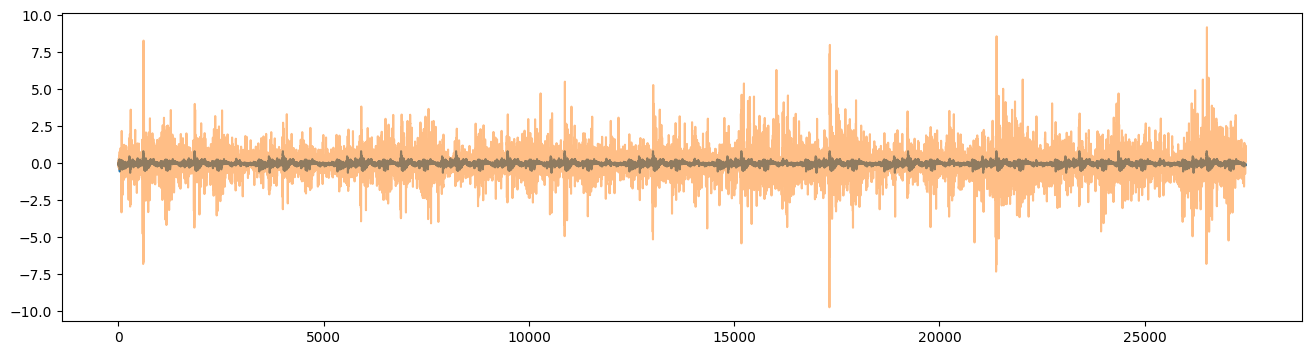

In [12]:
model = LinearRegression()
model.fit(train_indicator_df.values, train_target_df.values)
preds = model.predict(test_indicator_df.values)

plt.plot(preds, label='Predictions')
plt.plot(test_target_df.values, label='True Values', alpha=0.5)

Correlation Coefficient: 0.08257883338005641


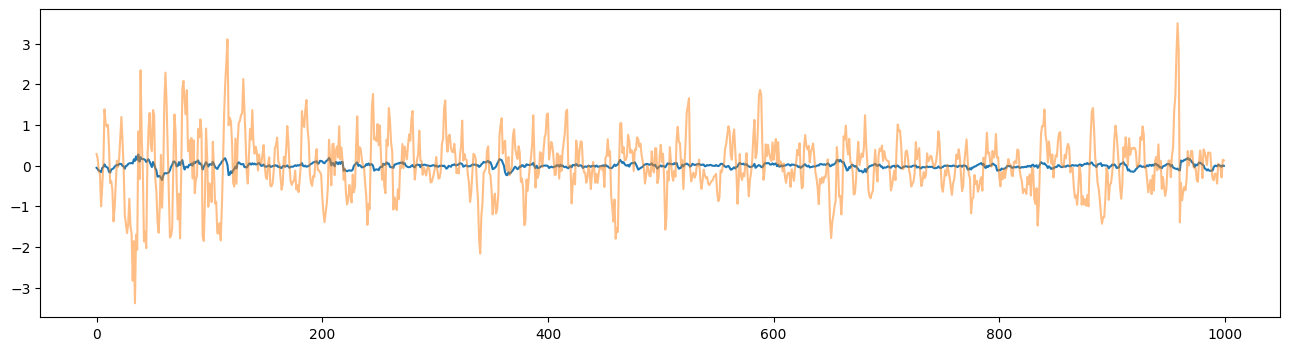

In [13]:
model = LinearRegression()
model.fit(train_indicator_df.values, train_target_df.values)
preds = model.predict(train_indicator_df.values)

plt.plot(preds[-1000:], label='Predictions')
plt.plot(train_target_df.values[-1000:], label='True Values', alpha=0.5)

corr_coef = np.corrcoef(preds.flatten(), train_target_df.values.flatten())[0, 1]
print("Correlation Coefficient:", corr_coef)

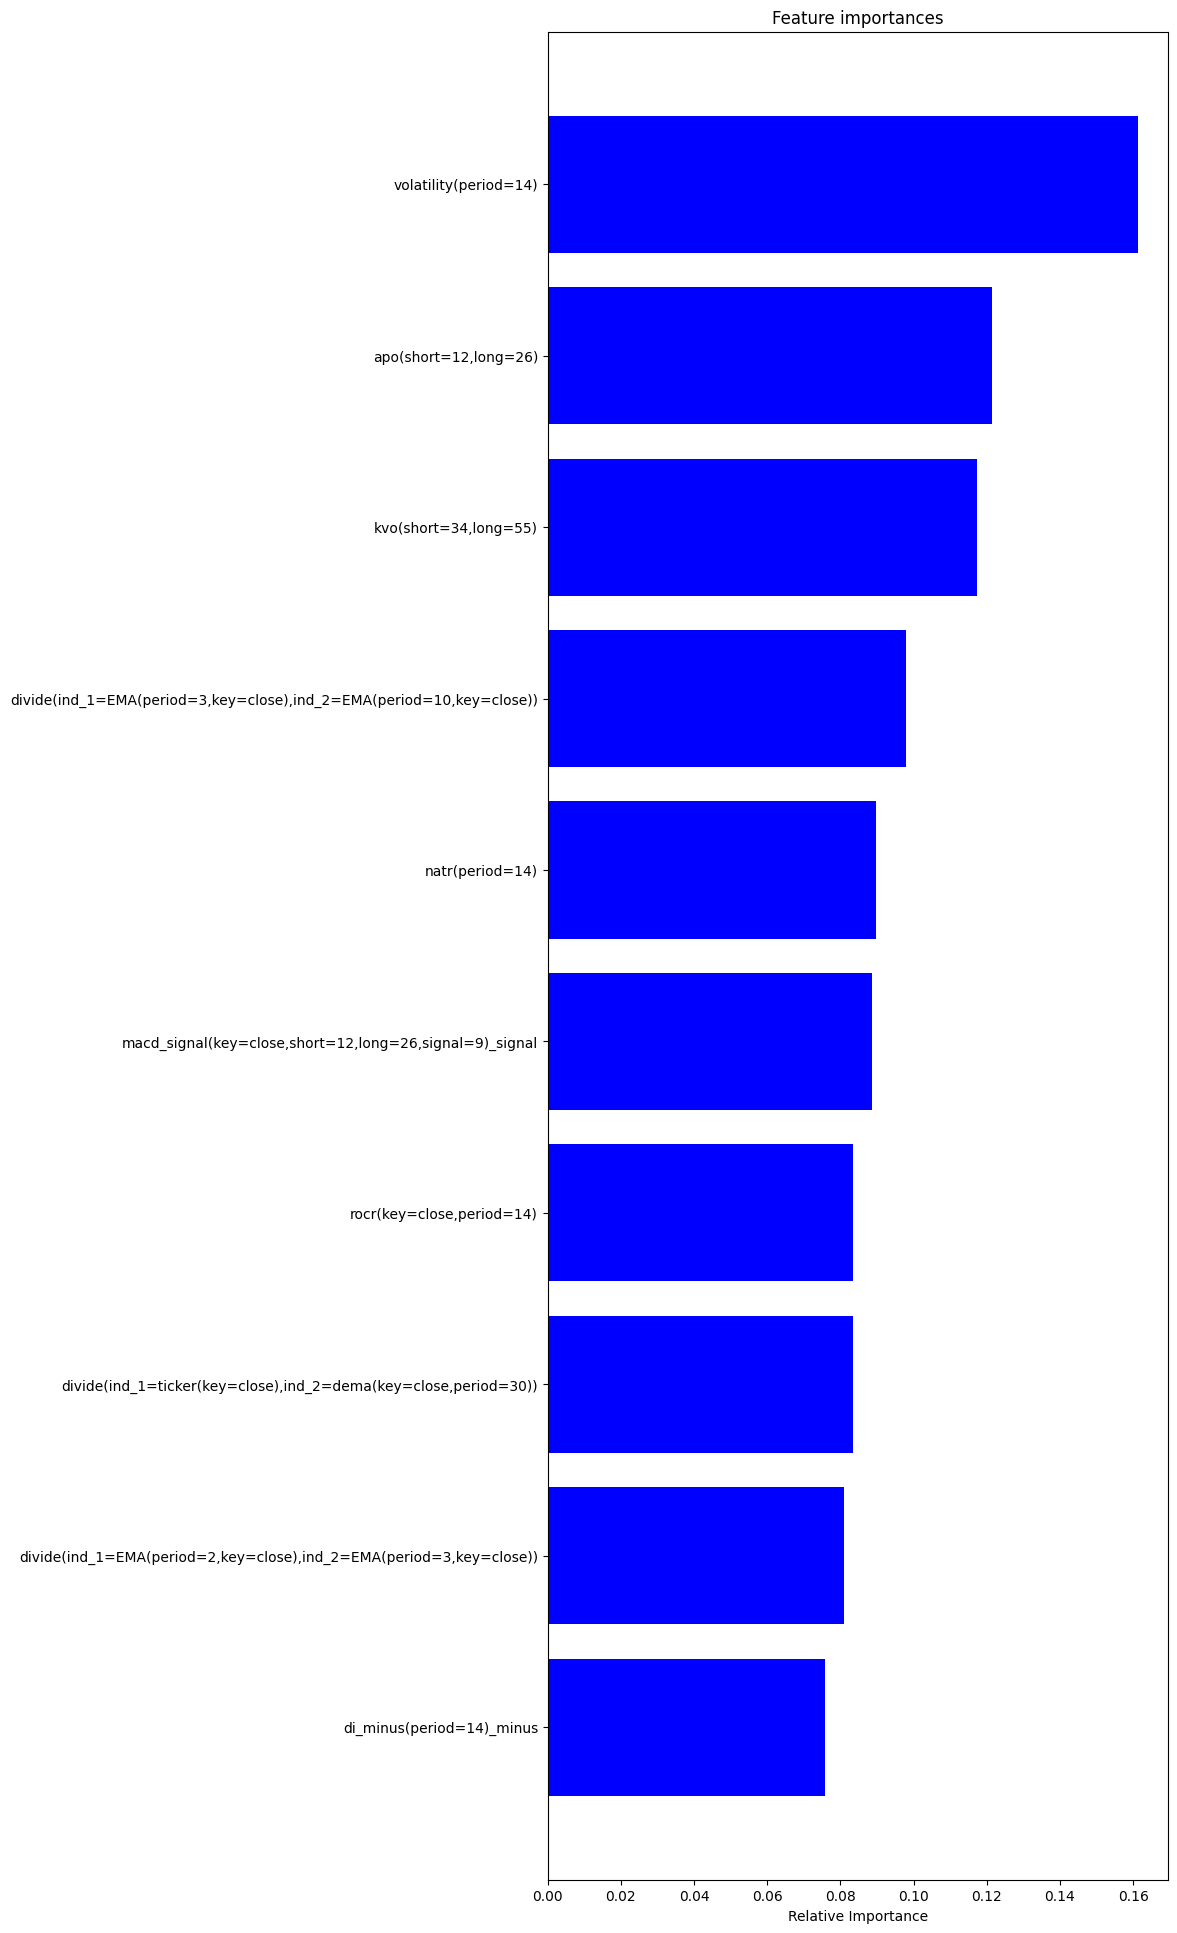

In [ ]:
# see which features are most important in RandomForestRegressor(
cols = train_indicator_df.columns
order = np.argsort(model.feature_importances_)
importances = model.feature_importances_[order]
indices = np.arange(len(importances))
plt.figure(figsize=(8, 24))
plt.title("Feature importances")
plt.barh(indices, importances, color="b", align="center")
plt.yticks(indices, cols[order])
plt.xlabel("Relative Importance")
plt.show()



In [ ]:
def segment_with_overlap(data, seg_s=None, seg_n: int = None, overlap_s: float = None, overlap_n: int = None, fs: int = None):
    """
    Returns a view into data of shape [num_channels, num_seg, num_samples] with ability to overlap

    Input
    ------
    data: np.array
        Data of shape [num_channels, num_samples]. Must be 2d (for vectors, use np.reshape(1, -1))
    seg_s/seg_n: float
        Length of segments in seconds/samples
    overlap_s/overlap_n: float
        Amount of overlap in seconds/samples.
    fs: int
        Sampling frequency

    Returns
    -------
    segments : np.array
        Segmented data of shape [num_channels, num_seg, num_samples]
    """
    if  len(data.shape) != 2:
        raise ValueError("Data must be 2d. try adding a dimension with np.reshape(1, -1)")
    assert ((seg_s is not None) and (fs is not None)) or (
                seg_n is not None), "Must specify either seg_s and fs or seg_n"
    assert ((overlap_s is not None) and (fs is not None)) or (
                overlap_n is not None), "Must specify either overlap_s and fs or overlap_n"
    if seg_s is not None:
        seg_n = int(seg_s * fs)
    if overlap_s is not None:
        overlap_n = int(overlap_s * fs)
    stride = seg_n - overlap_n  # step size between segments
    n_seg = (data.shape[-1] - seg_n) // stride + 1  # number of segments
    shape = (data.shape[0], int(n_seg), seg_n)  # output shape
    element_size = data.strides[-1]  # size of each data element in bytes
    strides = (data.strides[0], stride * element_size, element_size)
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

In [ ]:
#compare with other methods
lag_dim = 3

#Now try with lagged features lagged feature array
#create lagged values
x_train_lagged = segment_with_overlap(train_indicator_df.values.T, seg_n = lag_dim, overlap_n = lag_dim-1)
x_train_lagged = x_train_lagged.swapaxes(0,1)
x_train_lagged = x_train_lagged.reshape(x_train_lagged.shape[0], -1)
y_train_lagged = train_target_df.values[-len(x_train_lagged):]

x_test_lagged = segment_with_overlap(test_indicator_df.values.T, seg_n = lag_dim, overlap_n = lag_dim-1)
x_test_lagged = x_test_lagged.swapaxes(0,1)
x_test_lagged = x_test_lagged.reshape(x_test_lagged.shape[0], -1)
y_test_lagged = test_target_df.values[-len(x_test_lagged):]

#linear regression
lr = LinearRegression()
now = datetime.now()
lr.fit(x_train_lagged, y_train_lagged)
preds = lr.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Linear Regression:", mse)
print("Elapsed time:", datetime.now() - now)
print()

#ridge regression
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], store_cv_values=True)
now = datetime.now()
ridge.fit(x_train_lagged, y_train_lagged)
preds = ridge.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Ridge Regression:", mse)
print("Elapsed time:", datetime.now() - now)
print()

#lasso
lasso = LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)
now = datetime.now()
lasso.fit(x_train_lagged, y_train_lagged)
preds = lasso.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Lasso Regression:", mse)
print("Elapsed time:", datetime.now() - now)
print()

dtr = DecisionTreeRegressor()
now = datetime.now()
dtr.fit(x_train_lagged, y_train_lagged)
preds = dtr.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Decision Tree Regression:", mse)
print("Elapsed time:", datetime.now() - now)
print()

#random forest
rfr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
now = datetime.now()
rfr.fit(x_train_lagged, y_train_lagged)
preds = rfr.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged Random Forest Regressor:", mse)
print("Elapsed time:", datetime.now() - now)
print()

#svr
svr = SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=.1)
now = datetime.now()
svr.fit(x_train_lagged, y_train_lagged)
preds = svr.predict(x_test_lagged)
mse = np.mean((preds - y_test_lagged)**2)
print("Lagged SVR:", mse)
print("Elapsed time:", datetime.now() - now)
print()

Lagged Linear Regression: 0.8947769254636311
Elapsed time: 0:00:00.090343



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Lagged Ridge Regression: 0.8876625061061743
Elapsed time: 0:00:05.354338



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lagged Lasso Regression: 0.8776186068564821
Elapsed time: 0:00:05.771352

Lagged Decision Tree Regression: 1.3162718751016909
Elapsed time: 0:00:10.213682



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Lagged Random Forest Regressor: 0.9097701276039224
Elapsed time: 0:02:25.561340



c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
